In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d gti-upm/leapgestrecog

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.13G/2.13G [01:08<00:00, 37.8MB/s]
100% 2.13G/2.13G [01:08<00:00, 33.5MB/s]


In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D
from tensorflow.keras import datasets, layers, models
import plotly.express as px
import random
from sklearn.metrics import accuracy_score,mean_squared_error

In [8]:
import zipfile

# Specify the path to the downloaded dataset
zip_file_path = '/content/leapgestrecog.zip'
extract_path = '/content/leapgestrecog/leapGestRecog'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully.")


Dataset unzipped successfully.


In [9]:
# List all files in the dataset directory
for dirname, _, filenames in os.walk(extract_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0079.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0114.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0045.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0040.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0102.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0010.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0163.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0172.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0156.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0134.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_09_0153.png
/content/leapgestrecog/leapGestRecog/leapGestRecog/01/09_c/frame_01_0

In [11]:
# Categories and image size
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# Paths for dataset
data_path = "/content/leapgestrecog/leapGestRecog"


In [15]:
# Loading the images and their classes (0 - 9)
image_data = []
for dr in os.listdir(data_path):
    if os.path.isdir(os.path.join(data_path, dr)):
        for category in CATEGORIES:
            class_index = CATEGORIES.index(category)
            path = os.path.join(data_path, dr, category)
            if os.path.exists(path):
                for img in os.listdir(path):
                    try:
                        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                        resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                        image_data.append([resized_arr, class_index])
                    except Exception as e:
                        pass


In [16]:
# Displaying the first element to ensure data loading
print(image_data[0])

[array([[4, 5, 6, ..., 4, 4, 4],
       [6, 6, 6, ..., 4, 3, 5],
       [5, 6, 6, ..., 4, 4, 3],
       ...,
       [5, 6, 6, ..., 5, 5, 5],
       [4, 5, 5, ..., 5, 4, 5],
       [5, 5, 5, ..., 4, 4, 4]], dtype=uint8), 0]


In [19]:
# Shuffle the data to ensure a mix of different categories
random.shuffle(image_data)


In [20]:
# Separate features and labels
X = []
y = []

for features, label in image_data:
    X.append(features)
    y.append(label)

# Convert to numpy arrays and reshape
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Adding a single channel dimension
y = np.array(y)

# Normalize pixel values to the range [0, 1]
X = X / 255.0

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Verify the shapes of the data and labels
print(f"X[0]: {X[0].shape}, y[0]: {y[0]}")

Data shape: (20000, 50, 50, 1), Labels shape: (20000,)
X[0]: (50, 50, 1), y[0]: 0


In [22]:
## Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [39]:
import numpy as np
import pandas as pd
import plotly.express as px

# Visualize the label distribution
unique_labels, counts = np.unique(y_train, return_counts=True)
labels = pd.Series(counts, index=unique_labels).sort_index()

colors = ['#FF6B6B', '#FFD93D', '#9BDE7A', '#6495ED', '#FF69B4', '#8B00FF', '#00CED1', '#FF7F50', '#9370DB', '#00FA9A']

fig = px.bar(
    x=labels.index,
    y=labels.values,
    title="Labels and their images",
    labels={"x": "Label", "y": "Number of Images"},
    text=labels.values,
    color=labels.index,
    color_discrete_sequence=colors
)

fig.update_layout(
    title_x=0.5,
    title_font_color="#fff",
    title_font_size=20,
    paper_bgcolor="#000000",
    font_color="#fff",
    plot_bgcolor="#000000",
    xaxis=dict(
        tickmode='linear',
        ticktext=labels.index
    ))

fig.update_yaxes(showgrid=False)
fig.update_traces(textfont_color='purple')
fig.show()

In [23]:
# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # Assuming 10 gesture classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(data_gen.flow(X_train, y_train, batch_size=32),
                    epochs=20,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) // 32)

Epoch 1/20
400/400 [==============================] - 56s 138ms/step - loss: 1.4747 - accuracy: 0.4619 - val_loss: 0.9142 - val_accuracy: 0.6284
Epoch 2/20
400/400 [==============================] - 50s 126ms/step - loss: 0.5713 - accuracy: 0.8037 - val_loss: 0.3203 - val_accuracy: 0.8938
Epoch 3/20
400/400 [==============================] - 52s 130ms/step - loss: 0.3406 - accuracy: 0.8845 - val_loss: 0.2359 - val_accuracy: 0.9234
Epoch 4/20
400/400 [==============================] - 50s 125ms/step - loss: 0.2473 - accuracy: 0.9175 - val_loss: 0.2323 - val_accuracy: 0.9291
Epoch 5/20
400/400 [==============================] - 53s 133ms/step - loss: 0.2066 - accuracy: 0.9320 - val_loss: 0.1274 - val_accuracy: 0.9597
Epoch 6/20
400/400 [==============================] - 53s 132ms/step - loss: 0.1808 - accuracy: 0.9380 - val_loss: 0.1771 - val_accuracy: 0.9337
Epoch 7/20
400/400 [==============================] - 49s 123ms/step - loss: 0.1443 - accuracy: 0.9528 - val_loss: 0.0785 - val_ac

In [29]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Calculate accuracy and mean squared error
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Accuracy:", accuracy)
print("Mean Squared Error:", mse)


125/125 [==============================] - 3s 27ms/step - loss: 0.0923 - accuracy: 0.9732
Test accuracy: 0.9732499718666077
125/125 [==============================] - 4s 27ms/step
Accuracy: 0.97325
Mean Squared Error: 0.3915


In [24]:
# Save the model for future use
model.save("hand_gesture_model.h5")


Text(0.5, 1.0, 'Training and Validation Accuracy')

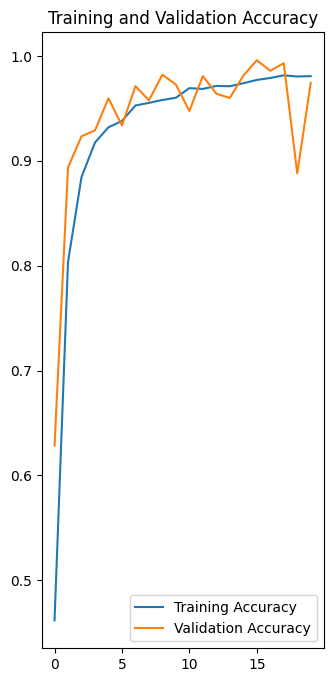

In [26]:
# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



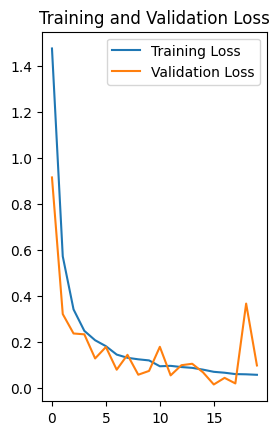

In [27]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 97ms/step
The predicted gesture is: 06_index


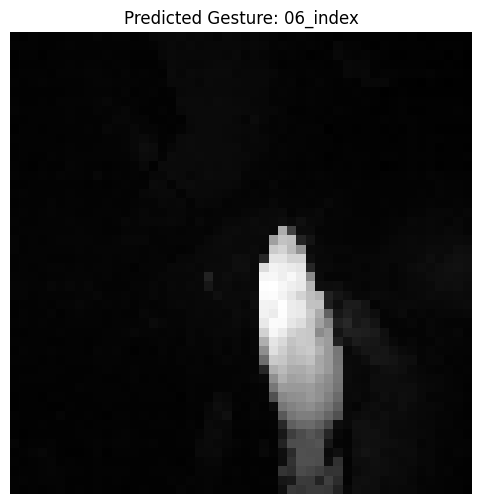

In [33]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('hand_gesture_model.h5')

# Load and preprocess the specific image

image_path = '/content/leapgestrecog/leapGestRecog/00/01_palm/frame_00_01_0005.png'
new_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
new_image = cv2.resize(new_image, (IMG_SIZE, IMG_SIZE))
new_image = new_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)
new_image = new_image / 255.0

# Make a prediction
prediction = model.predict(new_image)
predicted_class = np.argmax(prediction)

# Print the predicted gesture
print(f"The predicted gesture is: {CATEGORIES[predicted_class]}")

# Display the input image
plt.figure(figsize=(6, 6))
plt.imshow(new_image[0, :, :, 0], cmap='gray')
plt.title(f"Predicted Gesture: {CATEGORIES[predicted_class]}")
plt.axis('off')
plt.show()